In [23]:
# Importing the librariess

import seaborn as sns 
import pandas as pd
import matplotlib.pyplot as plt
import json,os
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from collections import Counter
# sentiment analysis 

import fuzzywuzzy
from fuzzywuzzy import process
import chardet
from collections import Counter
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
import nltk
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize
import warnings
warnings.filterwarnings('ignore')
import re
from wordcloud import WordCloud, STOPWORDS
#viz
import matplotlib.pyplot as plt
import seaborn as sns 
import matplotlib.gridspec as gridspec 

# graph viz
import plotly.offline as pyo

from plotly.graph_objs import *
import plotly.graph_objs as go

#map section
import imageio
import folium
import folium.plugins as plugins
os.environ['PROJ_LIB'] = 'C:/Users/shouv/Anaconda3/Lib/site-packages/mpl_toolkits/basemap'
from mpl_toolkits.basemap import Basemap

#os.chdir("D:\CSP 571\yelp data")

business = pd.read_json('business.json', lines=True)

### First we will chek the columns of the business data

In [24]:
business.columns

Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars', 'review_count', 'is_open',
       'attributes', 'categories', 'hours'],
      dtype='object')

In [25]:
business.categories.isnull().sum()

482

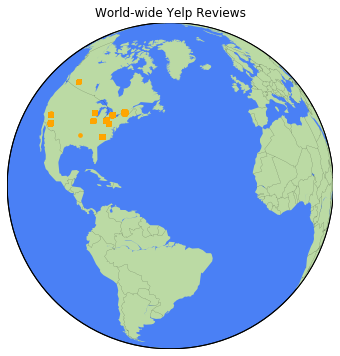

In [26]:
#basic basemap of the world
plt.figure(1, figsize=(15,6))
# use ortho projection for the globe type version
m1=Basemap(projection='ortho',lat_0=20,lon_0=-50)

# hex codes from google maps color pallete = http://www.color-hex.com/color-palette/9261
#add continents
m1.fillcontinents(color='#bbdaa4',lake_color='#4a80f5') 
# add the oceans
m1.drawmapboundary(fill_color='#4a80f5')                
# Draw the boundaries of the countires
m1.drawcountries(linewidth=0.1, color="black")

#Add the scatter points to indicate the locations of the businesses
mxy = m1(business["longitude"].tolist(), business["latitude"].tolist())
m1.scatter(mxy[0], mxy[1], s=3, c="orange", lw=3, alpha=1, zorder=5)
plt.title("World-wide Yelp Reviews")
plt.show()

Text(0.5, 1.0, 'North America Region')

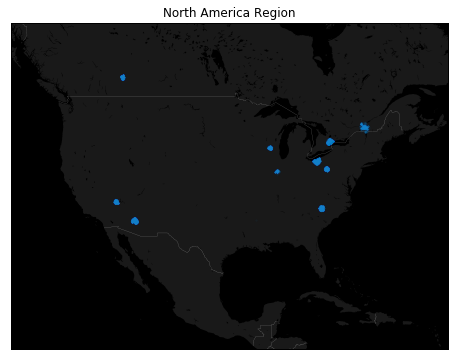

In [33]:
# Sample it down to only the North America region 
lon_min, lon_max = -132.714844, -59.589844
lat_min, lat_max = 13.976715,56.395664

#create the selector
idx_NA = (business["longitude"]>lon_min) &\
            (business["longitude"]<lon_max) &\
            (business["latitude"]>lat_min) &\
            (business["latitude"]<lat_max)
#apply the selector to subset
NA_business=business[idx_NA]

#initiate the figure
plt.figure(figsize=(12,6))
m2 = Basemap(projection='merc',
             llcrnrlat=lat_min,
             urcrnrlat=lat_max,
             llcrnrlon=lon_min,
             urcrnrlon=lon_max,
             lat_ts=35,
             resolution='i')

m2.fillcontinents(color='#191919',lake_color='#000000') # dark grey land, black lakes
m2.drawmapboundary(fill_color='#000000')                # black background
m2.drawcountries(linewidth=0.1, color="w")              # thin white line for country borders

# Plot the data
mxy = m2(NA_business["longitude"].tolist(), NA_business["latitude"].tolist())
m2.scatter(mxy[0], mxy[1], s=5, c="#1292db", lw=0, alpha=0.05, zorder=5)

plt.title("North America Region")
# Sample it down to only the Eurozone + Britain :p 
lon_min, lon_max = -8.613281,16.699219
lat_min, lat_max = 40.488737,59.204064

#create the selector
idx_euro = (business["longitude"]>lon_min) &\
            (business["longitude"]<lon_max) &\
            (business["latitude"]>lat_min) &\
            (business["latitude"]<lat_max)
#apply the selector to subset
euro_business=business[idx_euro]

#initiate the figure
plt.figure(figsize=(12,6))
m3 = Basemap(projection='merc',
             llcrnrlat=lat_min,
             urcrnrlat=lat_max,
             llcrnrlon=lon_min,
             urcrnrlon=lon_max,
             lat_ts=35,
             resolution='i')

m3.fillcontinents(color='#191919',lake_color='#000000') # dark grey land, black lakes
m3.drawmapboundary(fill_color='#000000')                # black background
m3.drawcountries(linewidth=0.1, color="w")              # thin white line for country borders

# Plot the data
mxy = m3(euro_business["longitude"].tolist(), euro_business["latitude"].tolist())
m3.scatter(mxy[0], mxy[1], s=5, c="#1292db", lw=0, alpha=0.05, zorder=5)

plt.title("Europe Region")
plt.show()

In [12]:
business.categories = business.categories.fillna(" ")

In [13]:
business.categories.isnull().sum()

0

### Check whether there is any duplicate entry

In [14]:
business.business_id.describe()

count                     192609
unique                    192609
top       RZqsf4rQ0Bw35QLgSlR60g
freq                           1
Name: business_id, dtype: object

### Thus there are no duplicate entries since there is no recurring business ids 

In [16]:
business_overall = business.assign(categories = business.categories.str.split(', ')).explode('categories')
cat = business_overall.categories.value_counts()
cat = cat.to_frame().reset_index()
cat.columns = ['Categories', 'Count']
cat

,Categories,Count
0,Restaurants,59371
1,Shopping,31878
2,Food,29989
3,Home Services,19729
4,Beauty & Spas,19370
...,...,...
1296,Tonkatsu,1
1297,Eastern European,1
1298,Soba,1
1299,Osteopaths,1


### There are 1301 categories. We shall check top 10 categories.

In [8]:
cat= cat.sort_values(by = 'Count', ascending = False)

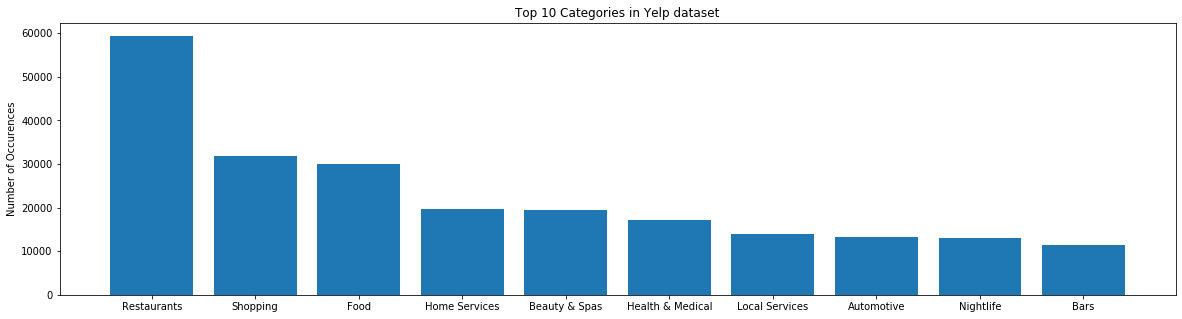

In [17]:
cat = cat[0:10]
objects = list(cat.Categories)
y_pos = np.arange(len(objects))
Numbers = list(cat.Count)

fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)
plt.bar(y_pos, Numbers, align='center', alpha=1)
plt.xticks(y_pos, objects)
plt.ylabel('Number of Occurences')
plt.title('Top 10 Categories in Yelp dataset')
plt.show()

### The most popular tag is Restaurants

### Now we will all those records which has 'Restaurant' or 'Food' in their categories column and store it in a dataframe

In [18]:
# categories = business.categories
# for i in categories:
#     if 'Restaurants' in i or 'Food' in i:
#         print(i)

In [19]:
# creating a dataframe to store all the records which has 'Restaurants' or 'Food' in their categories column
b = pd.DataFrame()
for i in business.index:
    if 'Restaurants' in business.categories[i] or 'Food' in business.categories[i]:
        b = b.append(business.iloc[i])

In [20]:
bus = b

In [21]:
bus['attributes'][1]

{'RestaurantsReservations': 'True',
 'GoodForMeal': "{'dessert': False, 'latenight': False, 'lunch': True, 'dinner': True, 'brunch': False, 'breakfast': False}",
 'BusinessParking': "{'garage': False, 'street': False, 'validated': False, 'lot': True, 'valet': False}",
 'Caters': 'True',
 'NoiseLevel': "u'loud'",
 'RestaurantsTableService': 'True',
 'RestaurantsTakeOut': 'True',
 'RestaurantsPriceRange2': '2',
 'OutdoorSeating': 'False',
 'BikeParking': 'False',
 'Ambience': "{'romantic': False, 'intimate': False, 'classy': False, 'hipster': False, 'divey': False, 'touristy': False, 'trendy': False, 'upscale': False, 'casual': True}",
 'HasTV': 'False',
 'WiFi': "u'no'",
 'GoodForKids': 'True',
 'Alcohol': "u'full_bar'",
 'RestaurantsAttire': "u'casual'",
 'RestaurantsGoodForGroups': 'True',
 'RestaurantsDelivery': 'False'}

In [22]:
# business = business.assign(categories = business.categories.str.split(', ')).explode('categories')
# count = business.categories.value_counts().tolist()
# res_cat = business.categories.tolist()
# res_cat = list(set(res_cat))

In [23]:
# count = business.categories.value_counts().tolist()
# categories_list = business.categories.str.split().tolist()
# categories_list

In [24]:
# business = business[business.categories.str.contains('Restaurants|Food|Nightlife|Bars', case=True,na=False)]
# business

In [25]:
# business = business.assign(categories = business.categories.str.split(', ')).explode('categories')
# business = business[business.categories.str.contains('Restaurants', case=True,na=False)]
# business

### We only need to focus on the restaurants which are open ( i.e. business.is_open ==1) 

In [26]:
# Taking into the consideration the businesses which are open
# 1 = open, 0 = closed
bus = bus[bus['is_open']==1]

## Taking average into consideration for all the US states

In [27]:
# taking into consideration US states only

states = pd.Series(["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"])

In [28]:
avg_stars = pd.pivot_table(bus[bus['state'].isin(states)] , index = ['state'], 
                    values = ['stars'], aggfunc = np.mean)

avg_stars=avg_stars.sort_values('stars',ascending=False)

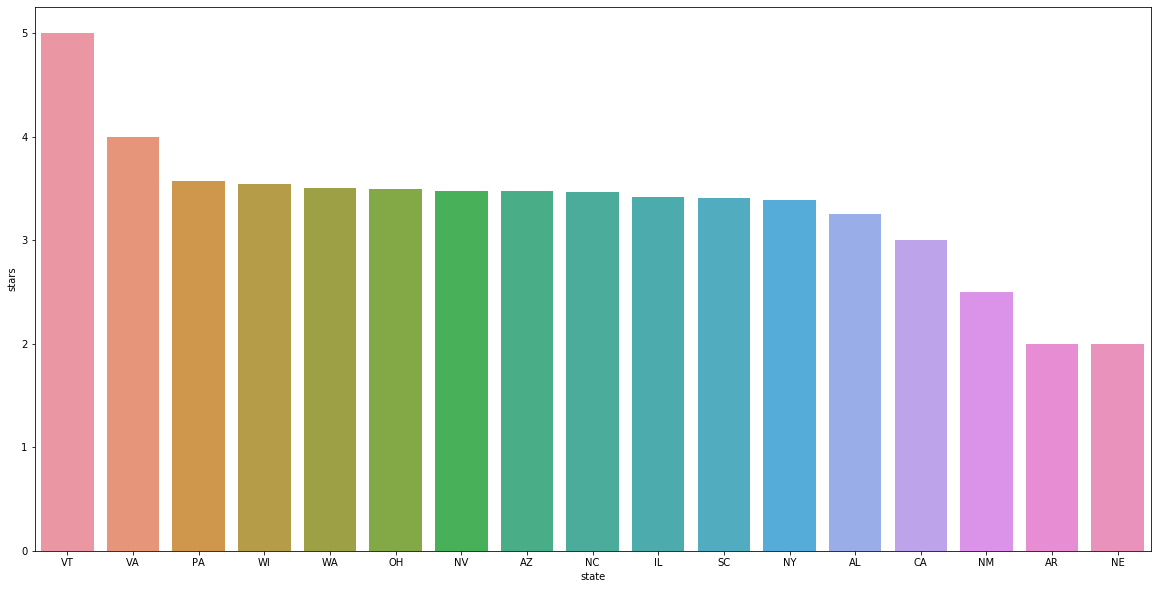

In [29]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
a = sns.barplot(x=avg_stars.index, y="stars", data=avg_stars)

### Now we shall see the distribution of state in this dataset

In [234]:
state_count = bus.state.value_counts()

In [235]:
state_count = state_count.to_frame().reset_index()
state_count.columns = ['State', 'Counts']

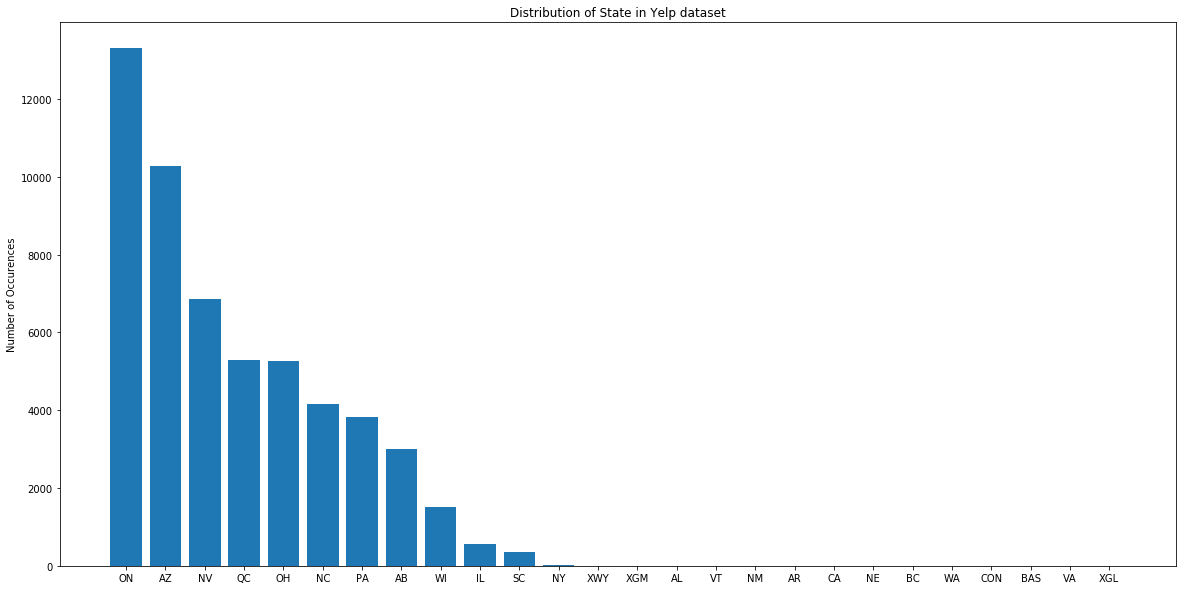

In [236]:
objects = list(state_count.State)
y_pos = np.arange(len(objects))
Numbers = list(state_count.Counts)

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
plt.bar(y_pos, Numbers, align='center', alpha=1)
plt.xticks(y_pos, objects)
plt.ylabel('Number of Occurences')
plt.title('Distribution of State in Yelp dataset')
plt.show()



### From this, graph, we see the statewise distribution of restaurants. As we can see, this data consists of restaurants present all over the world. For the sake of simplicity, we will focus on the restaurants present in Illinois.

In [33]:
business_in_IL = bus[bus.state == 'IL']

In [34]:
business_in_IL = business_in_IL.reset_index(drop = True)

In [35]:
business_in_IL

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,postal_code,review_count,stars,state
0,713 W Marketview Dr,"{'WiFi': 'u'no'', 'RestaurantsReservations': '...",mofOjB6flg-eAWOFbOkHfQ,"Sushi Bars, Buffets, Restaurants, Chinese",Champaign,"{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",1.0,40.137270,-88.256043,ChinaTown Buffet,61822,72.0,2.5,IL
1,1703 Philo Rd,"{'RestaurantsGoodForGroups': 'True', 'Business...",m4DwPVxmFDQE_FnGIOa3cQ,"Buffets, Chinese, Restaurants",Urbana,None,1.0,40.097639,-88.191217,Sunny China Buffet,61802,15.0,3.5,IL
2,207 W Clark St,"{'Alcohol': 'u'full_bar'', 'GoodForKids': 'Fal...",HbK6IfznbVToEaKVC0WcSg,"Karaoke, American (Traditional), Nightlife, Ta...",Champaign,"{'Tuesday': '16:0-2:0', 'Wednesday': '16:0-2:0...",1.0,40.115017,-88.246156,The Clark Bar,61820,24.0,3.5,IL
3,421 Town Center Rd,"{'RestaurantsTakeOut': 'True', 'RestaurantsAtt...",o9nGD3J0btXjE9M6IdgZTA,"Salad, Delis, Restaurants, Sandwiches, Food",Champaign,"{'Monday': '0:0-0:0', 'Tuesday': '10:30-21:0',...",1.0,40.141668,-88.250360,McAlister's Deli,61820,50.0,3.0,IL
4,1103 Klein Ave,"{'GoodForKids': 'False', 'BusinessAcceptsCredi...",sDfN5qJlmvrwTfwEPBsxSg,"Fast Food, Ice Cream & Frozen Yogurt, Restaura...",Rantoul,None,1.0,40.311299,-88.142882,Dairy Queen,61866,4.0,2.0,IL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558,410 N Race St,"{'RestaurantsTakeOut': 'True', 'Alcohol': 'u'n...",nD4cF5IH8RE7LFGdR2FMUA,"Hot Dogs, Restaurants, Burgers",Urbana,None,1.0,40.116172,-88.208663,Windy City Express,61801,28.0,3.5,IL
559,"410 E Green St, Ste 1","{'BusinessAcceptsCreditCards': 'True', 'BYOBCo...",zTGxLMOd9crAz0XNzqrcrA,"Restaurants, Chinese",Champaign,"{'Monday': '11:0-22:30', 'Tuesday': '11:0-22:3...",1.0,40.110638,-88.232483,Empire Chinese Restaurant,61820,48.0,3.5,IL
560,"701 S Gregory St, Ste A","{'RestaurantsDelivery': 'False', 'RestaurantsR...",0QgFIP9W0eGZSxCSQRQSCg,"Restaurants, Fast Food, Sandwiches",Urbana,None,1.0,40.106711,-88.221752,Subway,61801,6.0,2.5,IL
561,500 S Goodwin Ave,"{'RestaurantsTakeOut': 'True', 'BusinessAccept...",gZtJyb2oEpwo1rnovDVPfA,"Bakeries, Restaurants, Food, American (Traditi...",Urbana,"{'Monday': '7:30-15:30', 'Tuesday': '7:30-15:3...",1.0,40.108000,-88.222501,Intermezzo CafÃ©,61801,11.0,3.5,IL


In [36]:
type(business_in_IL.attributes[1])

dict

### The 'attribute' column contains features which we can use to make the recommendations more suitable for the users. For that, we have to break this column and store these features as different columns

In [37]:
def get_superset_of_column_names_from_file(data):
    column_names = set()
    
    for line_contents in data:
        column_names.update(
                set(get_column_names(line_contents))
                )
    return column_names

def get_column_names(line_contents):
    """Return a list of flattened key names given a dict.
    Example:
        line_contents = {
            'a': {
                'b': 2,
                'c': 3,
                },
        }
        will return: ['a.b', 'a.c']
    These will be the column names for the eventual csv file.
    """
    column_names = []
    if line_contents is None:
        return ''
    for k in line_contents.keys():
        column_names.append('{0}'.format(k)
        )
    
    return column_names

In [38]:
superset_cols = get_superset_of_column_names_from_file(business_in_IL.attributes)

# put all those columns in the dataset and initilize them to nan
for col in superset_cols:
    business_in_IL[col]= np.nan

In [39]:
idx = 0
for attr in business_in_IL.attributes:
    if attr is None:
        idx+=1
        continue
    for k,v in attr.items():
        if'{' in v:
            continue
        business_in_IL[k][idx] = v
    idx+=1

In [40]:
null_val = pd.DataFrame(business_in_IL.isna().sum())
print("Null values: ",null_val)
print('n')
print('\n')
print("Shape of original data", business_in_IL.shape)

Null values:                                0
address                       0
attributes                   24
business_id                   0
categories                    0
city                          0
hours                       112
is_open                       0
latitude                      0
longitude                     0
name                          0
postal_code                   0
review_count                  0
stars                         0
state                         0
BusinessAcceptsCreditCards   36
HappyHour                   533
GoodForDancing              534
RestaurantsTableService     443
ByAppointmentOnly           543
OutdoorSeating              164
Alcohol                     205
RestaurantsTakeOut           76
DietaryRestrictions         562
WheelchairAccessible        486
BusinessParking             552
RestaurantsPriceRange2       54
HasTV                       206
BYOBCorkage                 522
RestaurantsDelivery         146
RestaurantsReservations   

### As we see, the number of records in the dataset is 563 and there are few columns which have no value at all. Therefore, in order to keep the columns which will be most useful to us, we will drop rest of the columns. We will keep a threshold of 300 (if the columns have more than 300 null values, we will drop the column).

In [41]:
col_del = list(null_val[null_val.iloc[:,0] >300].index)# columns to keep
col_del

['HappyHour',
 'GoodForDancing',
 'RestaurantsTableService',
 'ByAppointmentOnly',
 'DietaryRestrictions',
 'WheelchairAccessible',
 'BusinessParking',
 'BYOBCorkage',
 'Ambience',
 'BusinessAcceptsBitcoin',
 'BestNights',
 'CoatCheck',
 'Corkage',
 'DriveThru',
 'Music',
 'Smoking',
 'DogsAllowed',
 'GoodForMeal']

In [42]:
business_in_IL.drop(columns=col_del).isna().sum()

address                         0
attributes                     24
business_id                     0
categories                      0
city                            0
hours                         112
is_open                         0
latitude                        0
longitude                       0
name                            0
postal_code                     0
review_count                    0
stars                           0
state                           0
BusinessAcceptsCreditCards     36
OutdoorSeating                164
Alcohol                       205
RestaurantsTakeOut             76
RestaurantsPriceRange2         54
HasTV                         206
RestaurantsDelivery           146
RestaurantsReservations       174
RestaurantsGoodForGroups      170
GoodForKids                   174
Caters                        221
BikeParking                   146
NoiseLevel                    227
WiFi                          206
RestaurantsAttire             189
dtype: int64

In [43]:
business_in_IL = business_in_IL.drop(columns=col_del)

### Now we will split the contents in 'category' attribute

In [44]:
# test-0
# category_ele = set()
# for i in business_in_IL.index:
#     elements = business_in_IL.categories[i].split(',')
#     category_ele.update(business_in_IL.categories[i].split(','))
#     for element in elements:
#         category_elements.update(element)
#         print(element)

In [45]:
# test-1
category_elements = []
for i in business_in_IL.index:
    elements = business_in_IL.categories[i].split(',')
#     category_elements.update(business_in_IL.categories[i].split(','))
    for element in elements:
        category_elements.append(element)
#         print(element)

In [46]:
category_elements = [x.strip(' ') for x in category_elements]
category_elements

['Sushi Bars',
 'Buffets',
 'Restaurants',
 'Chinese',
 'Buffets',
 'Chinese',
 'Restaurants',
 'Karaoke',
 'American (Traditional)',
 'Nightlife',
 'Tapas Bars',
 'Restaurants',
 'Salad',
 'Delis',
 'Restaurants',
 'Sandwiches',
 'Food',
 'Fast Food',
 'Ice Cream & Frozen Yogurt',
 'Restaurants',
 'Food',
 'Restaurants',
 'Asian Fusion',
 'Sushi Bars',
 'Pan Asian',
 'Restaurants',
 'Sushi Bars',
 'Japanese',
 'Noodles',
 'Coffee & Tea',
 'Food',
 'Restaurants',
 'Fast Food',
 'Food',
 'Burgers',
 'Coffee & Tea',
 'American (Traditional)',
 'Restaurants',
 'African',
 'Burgers',
 'Food',
 'Grocery',
 'Restaurants',
 'Street Vendors',
 'Mexican',
 'Food',
 'Herbs & Spices',
 'Food',
 'Coffee & Tea',
 'Specialty Food',
 'Restaurants',
 'Mexican',
 'Restaurants',
 'Sports Bars',
 'Restaurants',
 'American (New)',
 'Nightlife',
 'Burgers',
 'Vegetarian',
 'Seafood',
 'Bars',
 'Mexican',
 'Soul Food',
 'Mexican',
 'Asian Fusion',
 'Korean',
 'Food Trucks',
 'Restaurants',
 'Food',
 'Restau

In [47]:
# we are taking 20 most common categories
Counter(category_elements).most_common(20)

[('Restaurants', 457),
 ('Food', 248),
 ('Fast Food', 88),
 ('American (Traditional)', 74),
 ('Nightlife', 68),
 ('Sandwiches', 66),
 ('Bars', 62),
 ('Pizza', 61),
 ('Coffee & Tea', 60),
 ('Burgers', 54),
 ('Mexican', 47),
 ('Chinese', 44),
 ('Grocery', 38),
 ('Bakeries', 38),
 ('American (New)', 36),
 ('Breakfast & Brunch', 36),
 ('Specialty Food', 35),
 ('Ice Cream & Frozen Yogurt', 31),
 ('Shopping', 29),
 ('Event Planning & Services', 28)]

In [48]:
# category_ele = list(category_ele)
features = Counter(category_elements).most_common(20)
feature = [x[0] for x in features]

for col in feature:
    business_in_IL[col]= np.nan
# for i in feature:
#     print(str(i))
for i in feature:
    for index in business_in_IL.index:
        
        if i in business_in_IL.categories[index]:
            business_in_IL[i][index] = 1
        else:
            business_in_IL[i][index] = 0

In [51]:
(business_in_IL.columns)

Index(['address', 'attributes', 'business_id', 'categories', 'city', 'hours',
       'is_open', 'latitude', 'longitude', 'name', 'postal_code',
       'review_count', 'stars', 'state', 'BusinessAcceptsCreditCards',
       'OutdoorSeating', 'Alcohol', 'RestaurantsTakeOut',
       'RestaurantsPriceRange2', 'HasTV', 'RestaurantsDelivery',
       'RestaurantsReservations', 'RestaurantsGoodForGroups', 'GoodForKids',
       'Caters', 'BikeParking', 'NoiseLevel', 'WiFi', 'RestaurantsAttire',
       'Restaurants', 'Food', 'Fast Food', 'American (Traditional)',
       'Nightlife', 'Sandwiches', 'Bars', 'Pizza', 'Coffee & Tea', 'Burgers',
       'Mexican', 'Chinese', 'Grocery', 'Bakeries', 'American (New)',
       'Breakfast & Brunch', 'Specialty Food', 'Ice Cream & Frozen Yogurt',
       'Shopping', 'Event Planning & Services'],
      dtype='object')

In [254]:
business_in_IL.to_csv("Business_in_Illinois.csv")

### Now we will be using "Business_in_Illinois.csv" for further EDA and recommender system

In [52]:
## Checking for inconsistent Data
cities = business_in_IL['city'].unique()
cities

array(['Champaign', 'Urbana', 'Rantoul', 'Saint Joseph', 'Monticello',
       'Mahomet', 'Sidney', 'Fithian', 'Savoy', 'Ogden', 'St Joseph',
       'Tolono', 'Philo', 'Fisher', 'Villa Grove', 'Homer', 'Mansfield',
       'Gifford', 'Tuscola'], dtype=object)

In [53]:
## There only city with inconsistent name is Saint Joseph, so we will update that
business_in_IL['city'] = business_in_IL['city'].str.lower()
business_in_IL['city'] = business_in_IL['city'].str.strip()

def replace_matches(df, column, string_to_match, min_ratio = 80):
    strings = df[column].unique()
    matches = fuzzywuzzy.process.extract(string_to_match, strings, 
                                         limit=10, scorer=fuzzywuzzy.fuzz.token_sort_ratio)
    close_matches = [matches[0] for matches in matches if matches[1] >= min_ratio]
    rows_with_matches = df[column].isin(close_matches)
    df.loc[rows_with_matches, column] = string_to_match
    
for city in cities:
    replace_matches(business_in_IL, column='city', string_to_match=city)

business_in_IL['city'].unique()

array(['Champaign', 'Urbana', 'Rantoul', 'St Joseph', 'Monticello',
       'Mahomet', 'Sidney', 'Fithian', 'Savoy', 'Ogden', 'Tolono',
       'Philo', 'Fisher', 'Villa Grove', 'Homer', 'Mansfield', 'Gifford',
       'Tuscola'], dtype=object)

In [55]:
# city_il = business_in_IL.city.value_counts()
# city_il = city_il.to_frame().reset_index()
# city['latitude'] = business_in_IL[]
# city_il.columns = ['City', 'Counts']

fig = px.scatter_mapbox(business_in_IL, lat="latitude", lon="longitude", hover_name="city", color_discrete_sequence=["fuchsia"], zoom=3, height=300)
fig.update_layout(mapbox_style='open-street-map')
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [56]:
city_il = business_in_IL.city.value_counts()
city_il = city_il.to_frame().reset_index()
city_il.columns = ['City', 'Counts']
# labels = list(city_il.City)
# sizes = list(city_il.Counts)
# fig = plt.figure(figsize=(20,10))
# ax = fig.add_subplot(111)
# plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
# plt.axis('equal')
# plt.show()

###  Distribuiton of restaurant business in Illinois

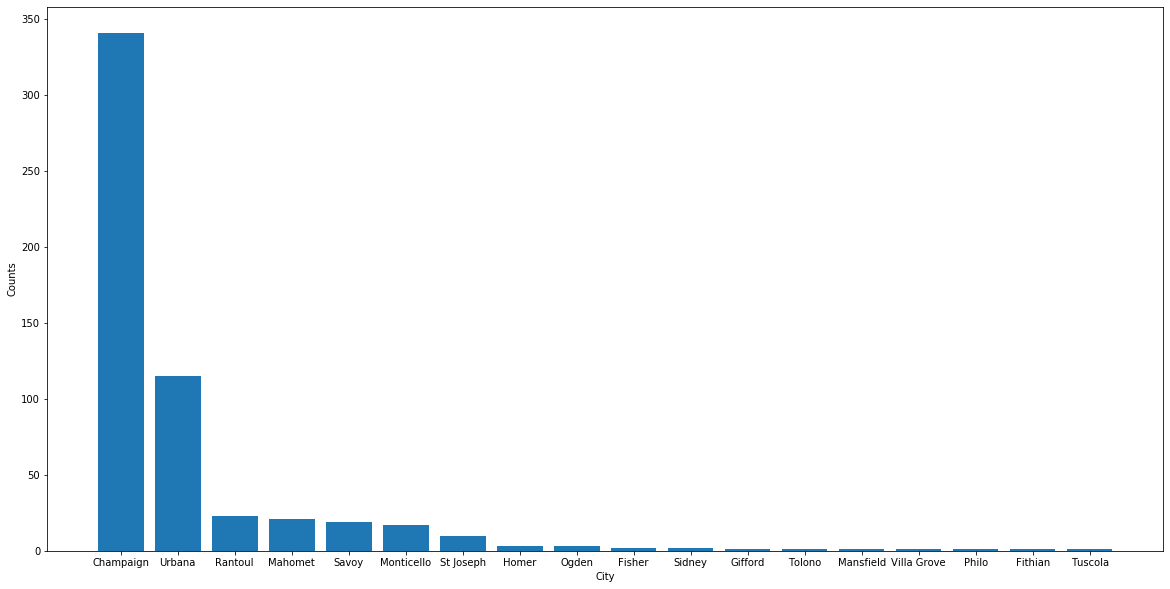

In [57]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
plt.bar(city_il.City, city_il.Counts, align = 'center', alpha = 1)
plt.xlabel("City")
plt.ylabel("Counts")
plt.show()


### Now we will check which all Restaurants got 5-star ratings and how much

In [58]:
reviews = []
with open(os.path.join(os.getcwd(), 'review.json'),encoding="utf8") as f:
    for line in f:
        reviews.append(json.loads(line))

In [59]:
reviews = pd.DataFrame(reviews)

In [60]:
business_ratings = pd.merge(business_in_IL, reviews[['review_id', 'business_id', 'stars']], on = 'business_id', how = 'left')

In [61]:
Five_star = business_ratings[business_ratings['stars_y'] == 5.0]

In [62]:
Five_star_order = Five_star.name.value_counts()

In [63]:
Five_star_order = Five_star_order.to_frame().reset_index()
Five_star_order.columns = ['Restaurant', 'Counts']


In [64]:
Five_star_order = Five_star_order.head(10)
Five_star_order = Five_star_order.sort_values(['Counts'], ascending = True)
Five_star_order

,Restaurant,Counts
9,Jarling's Custard Cup,124
8,Courier Cafe,126
7,Seven Saints,127
6,Farren's Pub & Eatery,128
5,Papa Del's Pizza,141
4,Sakanaya,232
3,DESTIHL Restaurant & Brew Works,243
2,Golden Harbor Authentic Chinese Cuisine,246
1,Maize Mexican Grill,350
0,Black Dog Smoke & Ale House,668


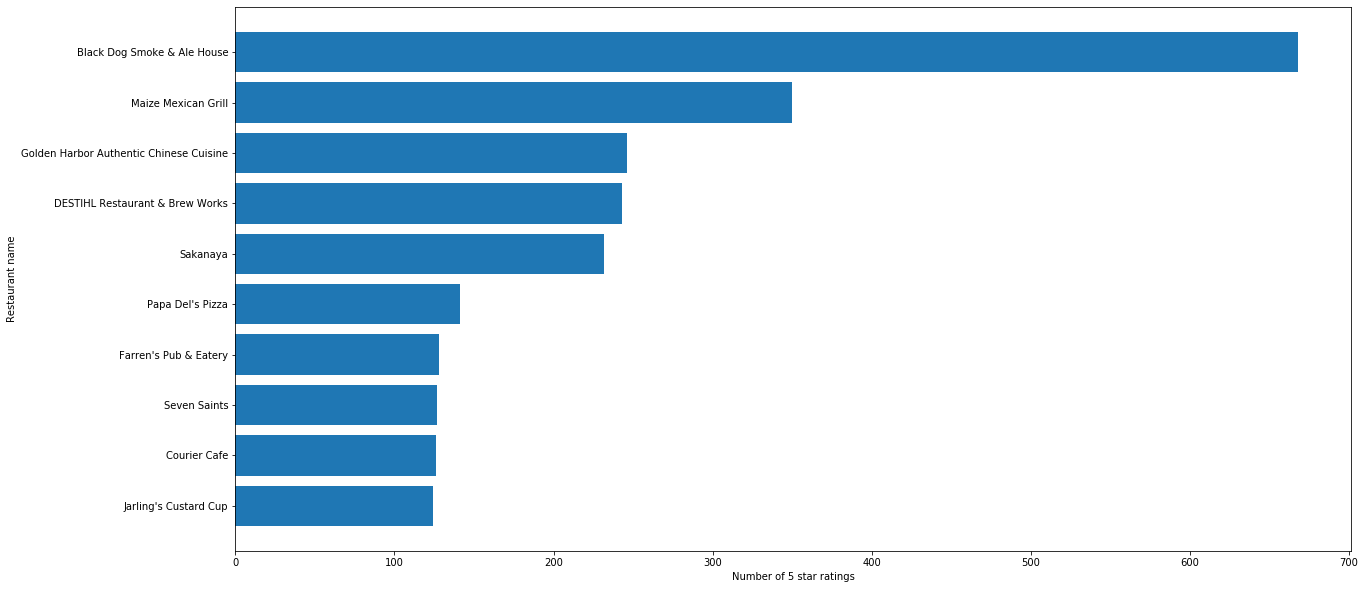

In [65]:
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot(111)
plt.barh(Five_star_order.Restaurant, Five_star_order.Counts, align = 'center', alpha = 1)
plt.ylabel('Restaurant name')
plt.xlabel('Number of 5 star ratings')
plt.show()

### We can deduce  Black Dog Smoke & Ale House got the highest amount of 5-star ratings.

In [66]:
reviews.columns

Index(['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny',
       'cool', 'text', 'date'],
      dtype='object')

In [67]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shouv\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [68]:
ids = business_in_IL.business_id.to_list()

In [69]:
review_IL = reviews[reviews.business_id.isin(ids)]
review_IL

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
157,DnjyWYnv95PjPx5tazakEg,dhUOHemaqOFWLC-mmLXAaw,LW21U6m6axC2lCLYc0fFSA,4.0,0,0,0,Their red velvet cupcakes are AMAZING! Their b...,2011-02-13 17:18:49
631,OBotxohcB9ZV_h8mPqRLDg,Xo3-DxgRbwm7p-McTyeqkw,5jak2hYO5ikUzjm-Ytao5A,2.0,1,0,0,Always slow service. They don't always have wh...,2015-04-28 19:28:49
746,TfJ2QlHY7sFdPpUyDi27Zg,c_vQnScwjEmPflK9ntnwmw,zswdqM8Av3KxVv9o7_6ORA,4.0,0,0,0,Everything was pretty good but the beef in the...,2017-07-08 17:24:58
796,8X_7hT5mlSRi7R_JOJTelw,wpXbsKs8J6YzapO04iXaYw,LW21U6m6axC2lCLYc0fFSA,4.0,1,0,0,I normally don't like fancy cupcakes because t...,2012-06-26 01:15:56
973,ilkuxI6oH3s1dEYW_Kxysw,_oxSgMz5Ryfs0NQFqy56Cw,SgG5E7PUrCIsEMP0BVSlTg,5.0,10,0,2,Very pleased with everything I've bought here:...,2013-10-03 11:36:25
...,...,...,...,...,...,...,...,...,...
6685229,eAiLTLujknK3uNcUNeG_uA,MvgEGMQ3kSI_LjmhqYYAFg,abA0s0uxoeOn7zNm-1dDxw,3.0,3,3,3,I have a neutral review of Mia Za's. Here are ...,2018-08-31 19:00:45
6685404,rzBwCHitUKFXZTGtqFdoKA,P-F0EwFFS-kscvsS4mauHw,-zEpEmDfFQL-ph0N3BDlXA,5.0,0,0,0,Best sushi in town! Lots of different rolls to...,2016-03-29 02:42:14
6685422,WXMEIncjSutaMJw_GAv3ig,2g-huKb0Q58EIqBlrpt86Q,bqiBdnyfYxTc4r8hY28q1g,4.0,0,0,0,"Chips warm, salsa medium heat, meal served qui...",2011-07-24 15:33:38
6685451,rCIV3-9d8Z0P40ByfDGVKA,pqNYhwPW37YZP6fWoTouvQ,pMiz7SP82Tknv1NbVqoSfg,5.0,0,0,0,Best bbq in town. It can take a bit to get a t...,2018-03-13 18:53:11


In [41]:
review_IL = pd.merge(review_IL, business_in_IL[['business_id', 'name']], on = 'business_id', how = 'left')
review_IL

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,name
0,TfJ2QlHY7sFdPpUyDi27Zg,c_vQnScwjEmPflK9ntnwmw,zswdqM8Av3KxVv9o7_6ORA,4.0,0,0,0,Everything was pretty good but the beef in the...,2017-07-08 17:24:58,Rainbow Garden
1,ilkuxI6oH3s1dEYW_Kxysw,_oxSgMz5Ryfs0NQFqy56Cw,SgG5E7PUrCIsEMP0BVSlTg,5.0,10,0,2,Very pleased with everything I've bought here:...,2013-10-03 11:36:25,Cheese and Crackers
2,X81JNJJg75edpHgT5nb7xw,9qAt7wTgl6mYtxPGZGwyWw,yRKrMWQxQaMeR18s5ajcYw,1.0,0,0,0,Nothing like paying $10+ for a container of cu...,2017-07-18 17:53:48,Arby's
3,qChAyy6hNJ4UmEk9XCCPAw,u7UaLSwFyxVOjD8n6V4ROA,SgG5E7PUrCIsEMP0BVSlTg,4.0,6,2,2,Modified my previous review after the store ow...,2013-12-28 23:48:40,Cheese and Crackers
4,dHKIplwLIyzXAr46944qYQ,lWSsSv9BVOK0JO8GGOhuNw,pCer-vIZM05p423MFmiSng,1.0,3,1,0,The service is terrible. \n\nWe had a huge gro...,2015-06-08 17:41:09,Kofusion
...,...,...,...,...,...,...,...,...,...,...
23670,eAiLTLujknK3uNcUNeG_uA,MvgEGMQ3kSI_LjmhqYYAFg,abA0s0uxoeOn7zNm-1dDxw,3.0,3,3,3,I have a neutral review of Mia Za's. Here are ...,2018-08-31 19:00:45,Mia Za's Cafe
23671,rzBwCHitUKFXZTGtqFdoKA,P-F0EwFFS-kscvsS4mauHw,-zEpEmDfFQL-ph0N3BDlXA,5.0,0,0,0,Best sushi in town! Lots of different rolls to...,2016-03-29 02:42:14,Sakanaya
23672,WXMEIncjSutaMJw_GAv3ig,2g-huKb0Q58EIqBlrpt86Q,bqiBdnyfYxTc4r8hY28q1g,4.0,0,0,0,"Chips warm, salsa medium heat, meal served qui...",2011-07-24 15:33:38,Mi Veracruz Mexican Grill
23673,rCIV3-9d8Z0P40ByfDGVKA,pqNYhwPW37YZP6fWoTouvQ,pMiz7SP82Tknv1NbVqoSfg,5.0,0,0,0,Best bbq in town. It can take a bit to get a t...,2018-03-13 18:53:11,Black Dog Smoke & Ale House


In [72]:
review_IL.to_csv("Review_IL_restaurants.csv")

### Top 10 most reviewed restaurants in Illinois

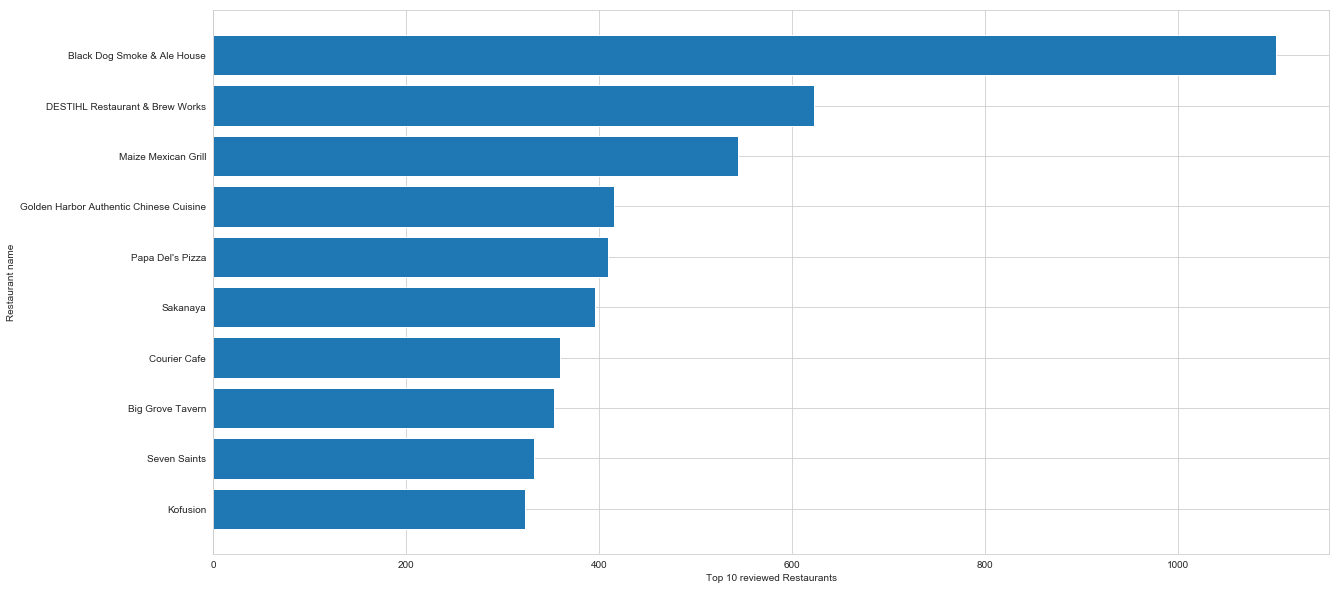

In [71]:
top10_most_reviewed = review_IL.name.value_counts()
top10_most_reviewed = top10_most_reviewed.to_frame().reset_index()
top10_most_reviewed = top10_most_reviewed.head(10)
top10_most_reviewed.columns = ['name', 'Counts']
top10_most_reviewed = top10_most_reviewed.sort_values(['Counts'], ascending = True)
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot(111)
plt.barh(top10_most_reviewed.name, top10_most_reviewed.Counts, align = 'center', alpha = 1)
plt.ylabel('Restaurant name')
plt.xlabel('Top 10 reviewed Restaurants')
plt.show()

In [42]:
review_IL['text'] = review_IL.text.str.replace("[^\w\s]", "").str.lower()

In [43]:
review_IL['text'] = review_IL['text'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop]))

In [44]:
Black_dog = review_IL[review_IL.name == 'Black Dog Smoke & Ale House']
Black_dog

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,name
9947,x20Vhj5qcBbW-08vEbFHOw,lg1UvP-7KLtjSdxbFbt3Aw,9MnbQg7kfb_WgxoV0hXKSQ,5.0,0,0,1,place without doubt best bbq illinois boyfrien...,2011-10-27 15:48:15,Black Dog Smoke & Ale House
9951,BUxau3CCZwnfPZrBt3vK0Q,Jd__AkH8jPv9wN6bfmTW1A,9MnbQg7kfb_WgxoV0hXKSQ,5.0,1,0,0,excellence bbq applesauce green beans sides go...,2018-02-24 02:32:05,Black Dog Smoke & Ale House
9957,2h1BHzhitC9ktYXcTfNqfA,dYAhuu1xauHTh-uhwnMcQw,9MnbQg7kfb_WgxoV0hXKSQ,4.0,0,0,0,beer flights food amazing cool server atmosphe...,2011-04-22 02:16:21,Black Dog Smoke & Ale House
9959,KGHDKrH6ptbvhTJ7NTdQSQ,eEbdbw_Tt6FvqB0Lv_03GA,9MnbQg7kfb_WgxoV0hXKSQ,5.0,0,0,0,burrito special thursday best burrito ive ever...,2016-02-11 22:14:01,Black Dog Smoke & Ale House
9960,lPCfdNu1OmI3QsZMIiBjyQ,Tu3EqdHkeEJeRzOvdvGORw,9MnbQg7kfb_WgxoV0hXKSQ,5.0,0,0,0,two words describe joint outstanding bbq eat m...,2012-04-28 21:31:09,Black Dog Smoke & Ale House
...,...,...,...,...,...,...,...,...,...,...
23639,eKGeqZypuH1TohZX0wTokw,2cKGJSnovT3uSjJxTmWfFA,pMiz7SP82Tknv1NbVqoSfg,5.0,0,0,0,favorite bbq place time far one favorite place...,2018-10-26 17:11:38,Black Dog Smoke & Ale House
23645,66L8Fd1z-wSIpTKH-BAKCQ,LVA5eEqCu_53LVPNGJhPpA,pMiz7SP82Tknv1NbVqoSfg,3.0,0,0,0,delicious meateaters grilled cheese vegetarian...,2017-08-17 20:11:30,Black Dog Smoke & Ale House
23648,InYyniCUT-rik_g06d20_w,qZNjFaaa87iYJSiL6kmAAQ,pMiz7SP82Tknv1NbVqoSfg,1.0,0,0,0,fan giving one star reviews warranted ate twic...,2018-10-27 08:55:26,Black Dog Smoke & Ale House
23652,7P2gi18OarIEGVTL6x1VJg,cFre2eN6hEcSOF96j0xSrQ,pMiz7SP82Tknv1NbVqoSfg,3.0,2,3,2,ill start saying love black dog aside maize fr...,2016-03-05 05:13:20,Black Dog Smoke & Ale House


### Sentiment Analysis on Review Dataset

In [45]:
# sentiment analysis on review dataset  
from collections import Counter
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
import nltk
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize
import re
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rahulnair/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [46]:
reviews_IL = reviews[reviews.business_id.isin(list(business_in_IL.business_id))]

In [47]:
# creating bag of words of all the text
bag_of_words = reviews_IL['text'].str.lower().str.cat(sep=' ')

In [48]:
bag_of_words = re.sub('[^A-Za-z]+', ' ', bag_of_words)
bag_of_words[0:1001]

'everything was pretty good but the beef in the mongolian beef was very chewy and had a weird texture i know this is always a chance when trying a new chinese restaurant the rest of the food was very good their noodles are really good and the fried rice very pleased with everything i ve bought here scallops salmon halibut trout the owner provides great customer service they just started carrying low acid coffee which we used to have to buy from trader joes in chicago ask to receive the fish and meat emails nothing like paying for a container of curly fry bits and pieces and a sandwich where the bun is actually more greasy that the bacon that was on it modified my previous review after the store owner s thoughtful response to feedback shared i respect small business owners that put in effort to follow up to feedback shared after his note i have gone back to the business and better understand what their focus areas are summary cheese crackers primarily is an order ahead market the name c

In [49]:
stop_words = list(get_stop_words('en'))         
nltk_words = list(stopwords.words('english'))   
stop_words.extend(nltk_words)

In [50]:
word_tokens = word_tokenize(bag_of_words)

In [51]:
filtered_sentence = []
for w in word_tokens:
    if w not in stop_words:
        filtered_sentence.append(w)

In [52]:
# Remove characters which have length less than 2  
without_single_chr = [word for word in filtered_sentence if len(word) > 3]

# Remove numbers
cleaned_data_title = [word for word in without_single_chr if not word.isnumeric()]

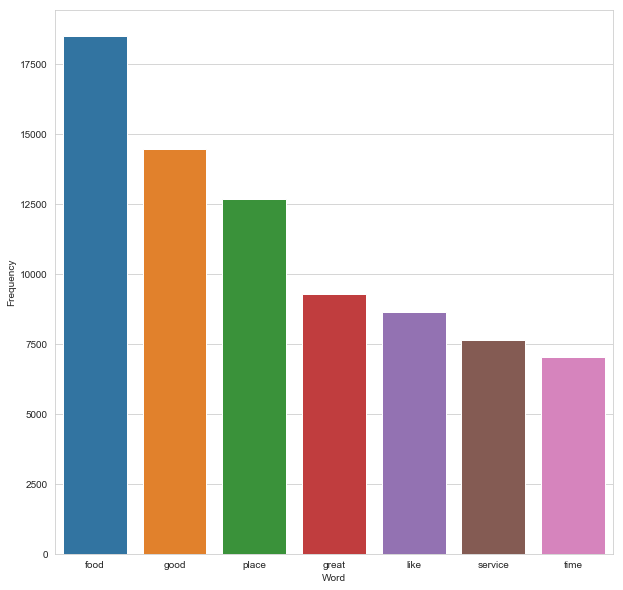

In [53]:
top_N = 100
word_dist = nltk.FreqDist(cleaned_data_title)
rslt = pd.DataFrame(word_dist.most_common(top_N),
                    columns=['Word', 'Frequency'])

plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.barplot(x="Word",y="Frequency", data=rslt.head(7))

In [54]:
def wc(data,bgcolor,title):
    plt.figure(figsize = (100,100))
    wc = WordCloud(background_color = bgcolor, max_words = 100,  max_font_size = 50)
    wc.generate(' '.join(data))
    plt.imshow(wc)
    plt.axis('off')

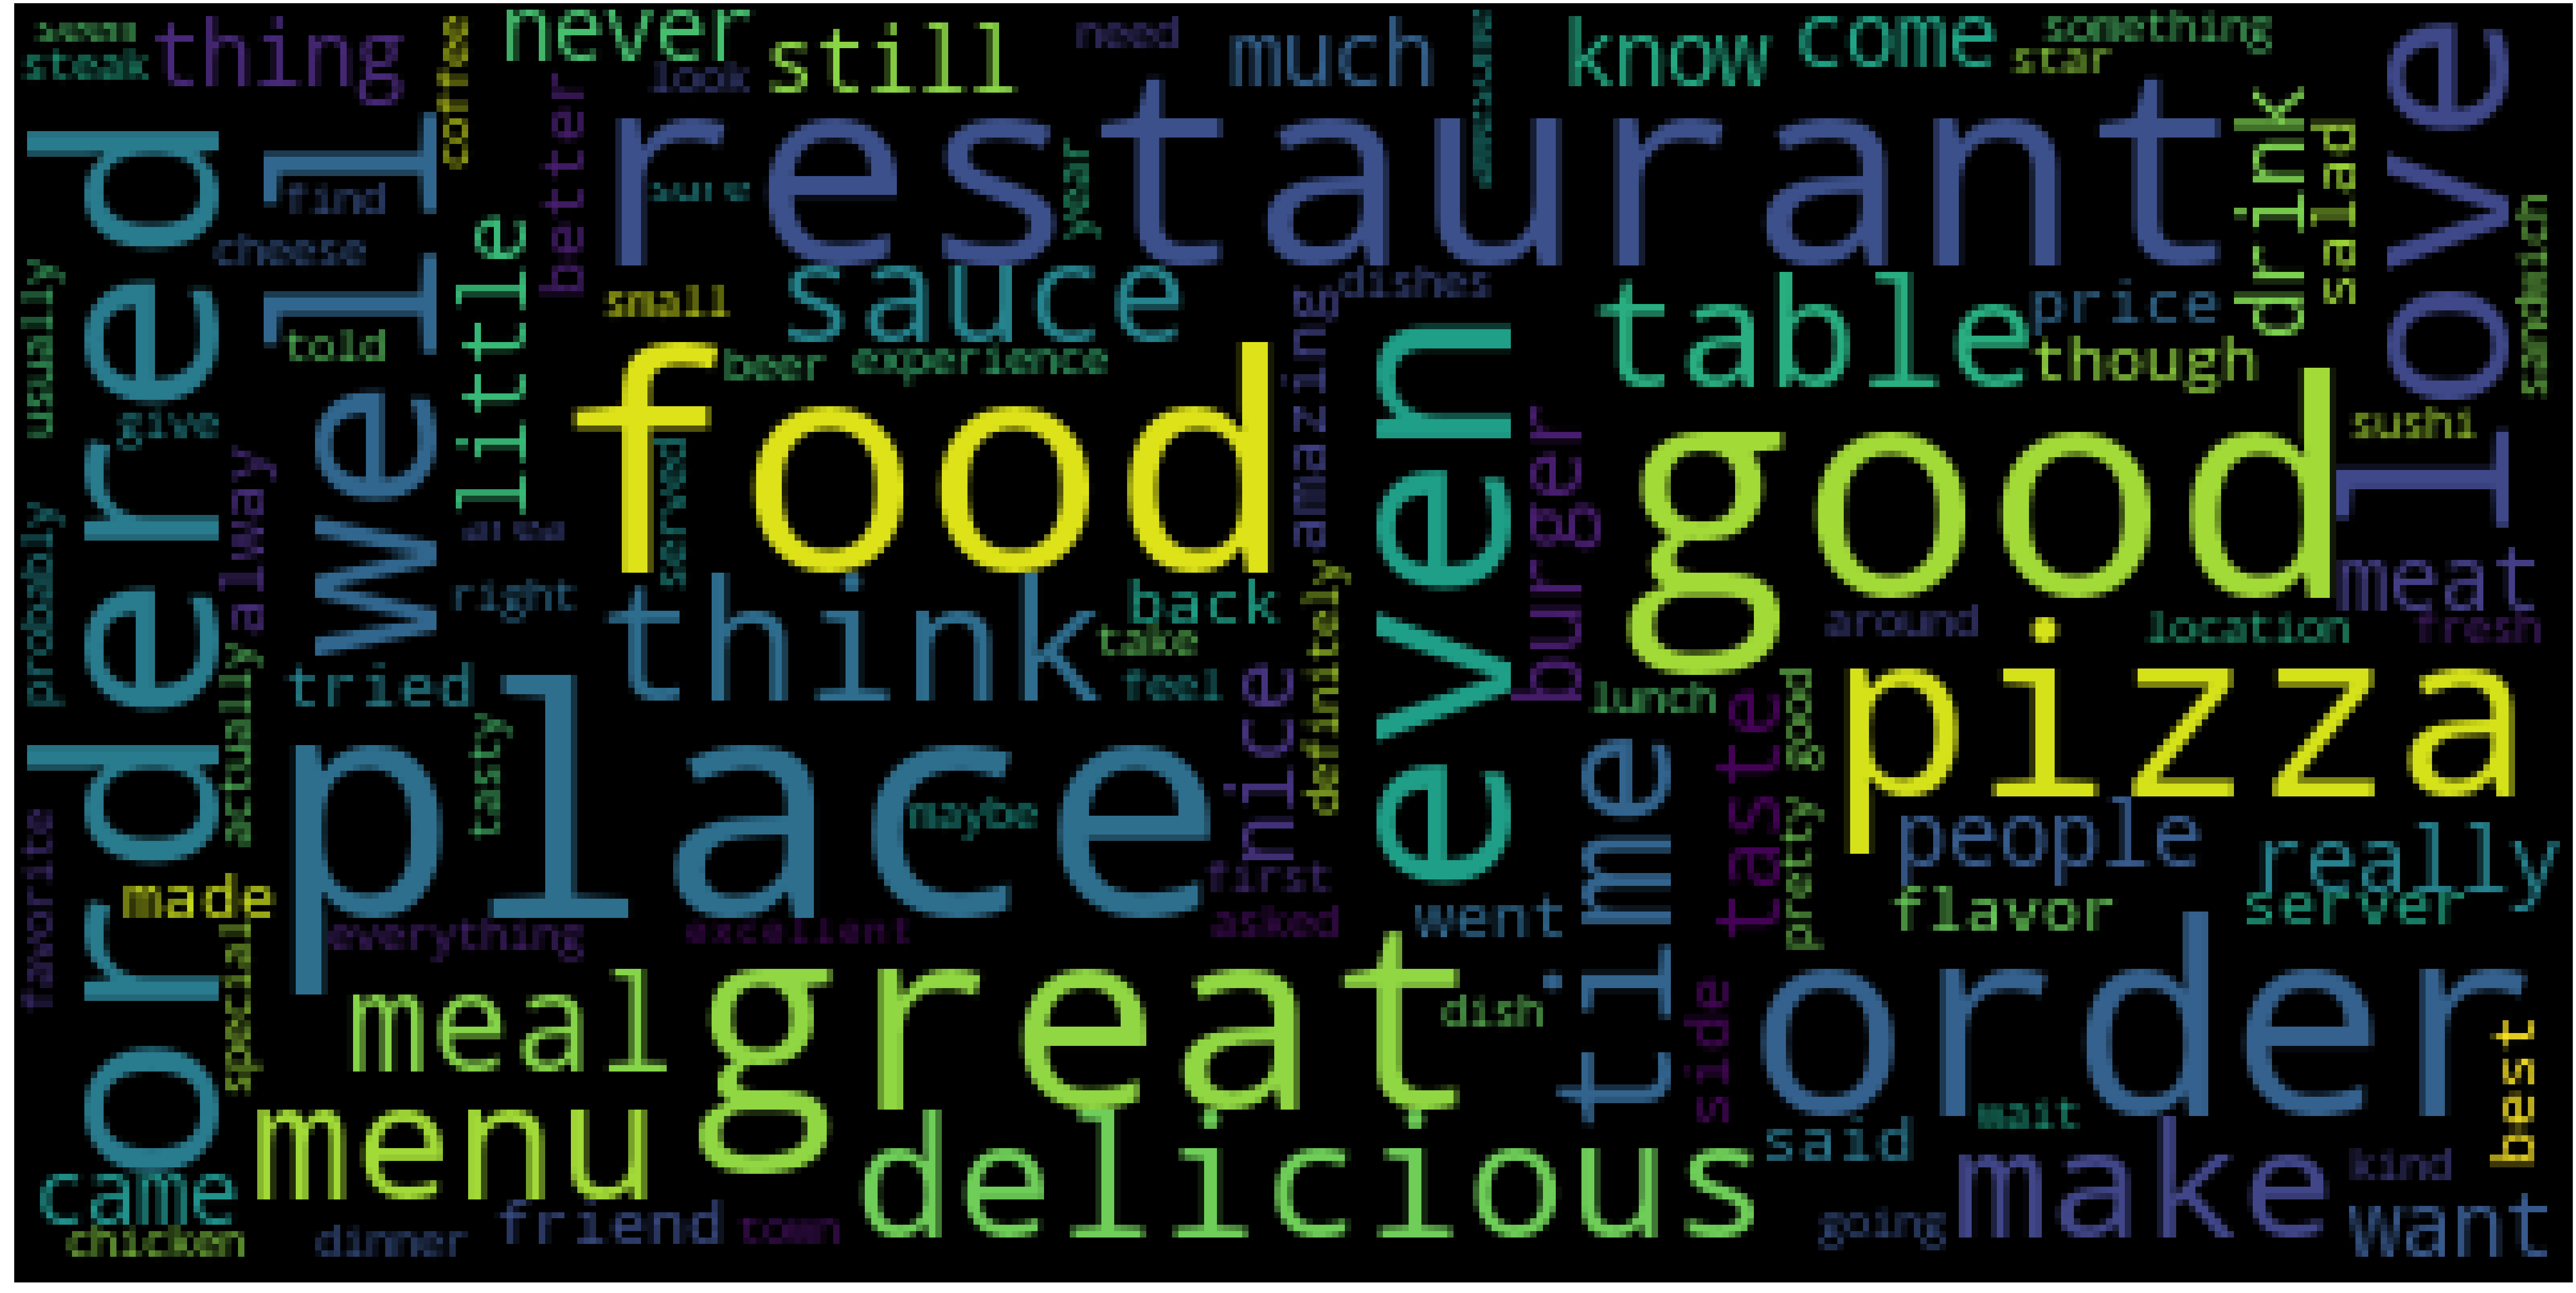

In [55]:
wc(cleaned_data_title,'black','Most Used Words')

In [56]:
from textblob import TextBlob

bloblist_desc = list()

df_review_str=reviews_IL['text'].astype(str)

In [57]:
for row in df_review_str:
    blob = TextBlob(row)
    bloblist_desc.append((row,blob.sentiment.polarity, blob.sentiment.subjectivity))
    df_polarity_desc = pd.DataFrame(bloblist_desc, columns = ['Review','sentiment','polarity'])

In [58]:
df_polarity_desc.head()

,Review,sentiment,polarity
0,Everything was pretty good but the beef in the...,0.310795,0.591818
1,Very pleased with everything I've bought here:...,0.483333,0.683333
2,Nothing like paying $10+ for a container of cu...,0.500000,0.500000
3,Modified my previous review after the store ow...,0.185498,0.512874
4,The service is terrible. \n\nWe had a huge gro...,-0.154545,0.480952


In [59]:
def f(df_polarity_desc):
    if df_polarity_desc['sentiment'] > 0:
        val = "Positive Review"
    elif df_polarity_desc['sentiment'] == 0:
        val = "Neutral Review"
    else:
        val = "Negative Review"
    return val

In [60]:
df_polarity_desc['Sentiment_Type'] =df_polarity_desc.apply(f,axis=1)

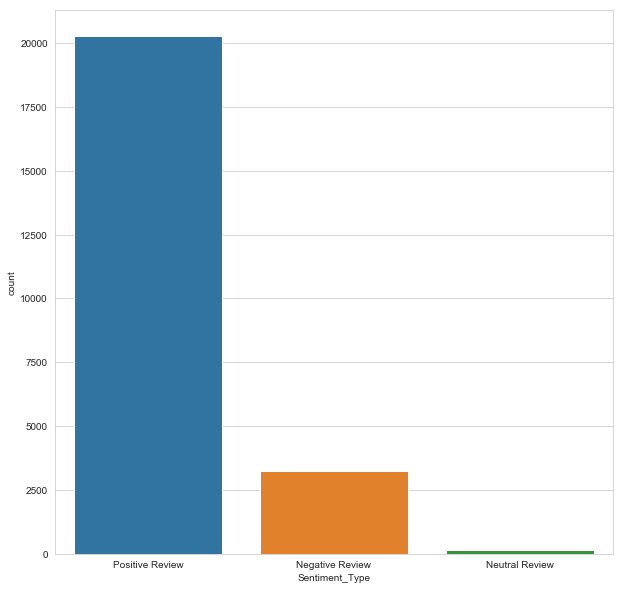

In [61]:
plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.countplot(x="Sentiment_Type", data=df_polarity_desc)

In [62]:
positive_reviews=df_polarity_desc[df_polarity_desc['Sentiment_Type']=='Positive Review']
negative_reviews=df_polarity_desc[df_polarity_desc['Sentiment_Type']=='Negative Review']

In [63]:
negative_reviews.head()

,Review,sentiment,polarity,Sentiment_Type
4,The service is terrible. \n\nWe had a huge gro...,-0.154545,0.480952,Negative Review
6,I would have given this restaurant zero stars ...,-0.206667,0.540000,Negative Review
16,So...no. Just...no. Before I picked up a plate...,-0.023377,0.420491,Negative Review
17,Having been to many other tgifridays I can say...,-0.189000,0.639000,Negative Review
25,Poor Chorizo super burrito. The Chorizo was b...,-0.033333,0.633333,Negative Review
